In [23]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_validate,cross_val_score, learning_curve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR

sns.set_style('whitegrid')
# Function to perform cross-validation and print results
def cross_validate_model(model, X, y, model_name, cv = 5 , n_jobs= 4):
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs= n_jobs)
    print(f"{model_name} Cross-validation RMSE Scores: {cv_results['test_neg_root_mean_squared_error']}")
    print(f"{model_name} Mean RMSE Score: {np.mean(cv_results['test_neg_root_mean_squared_error'])}")
    print(f"{model_name} Cross-validation R² Scores: {cv_results['test_r2']}")
    print(f"{model_name} Mean R² Score: {np.mean(cv_results['test_r2'])}\n")
    return cv_results


/tmp/ipykernel_2218/3914819708.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['significant_poss'] = (df['poss'] >= 500).astype(int)
/tmp/ipykernel_2218/3914819708.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['significant_poss'] = df['significant_poss'].astype('category')
/tmp/ipykernel_2218/3914819708.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

<AxesSubplot:xlabel='mp', ylabel='war_total'>

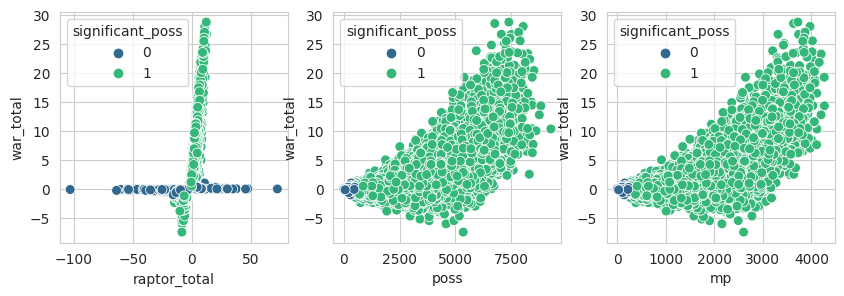

In [24]:
df_player = pd.read_csv('data/historical_RAPTOR_by_player.csv')
# I'll just keep war_total, raptor_total, pace impact. Also mp and poss
df = df_player[['player_name',	'player_id','poss',	'mp',	'raptor_total',	'war_total']]
# I will 'clusterize' by hand, dividing the data in two groups: less and more than 500 poss
df['significant_poss'] = (df['poss'] >= 500).astype(int)
# Convert 'significant_poss' to categorical type
df['significant_poss'] = df['significant_poss'].astype('category')
# replacing nan value in pace_impact col
df.at[12254, 'pace_impact'] = 0

f,axs = plt.subplots(ncols = 3 , figsize=(10, 3))
axs = axs.flatten()
sns.scatterplot(x='raptor_total', y='war_total', hue='significant_poss', palette='viridis', data=df, s=50, ax = axs[0])
sns.scatterplot(x='poss', y='war_total',  palette='viridis', hue='significant_poss', data=df, s=50, ax = axs[1])
sns.scatterplot(x='mp' , y='war_total', palette='viridis', hue='significant_poss', data=df, s=50, ax = axs[2])

In [25]:
# I will take the observations from high poss, since the others are probably described by another distribution, if any.
# Features (X) and target (y) for high possession
high_poss_df = df[df['significant_poss'] == 1]
X = high_poss_df[[ 'poss',	'mp',	'raptor_total']]  # features
y = high_poss_df['war_total']  # target variable



 order : 2 polynomial


2th polynomial Cross-validation RMSE Scores: [-0.02778281 -0.04919173 -0.03040478 -0.0296238  -0.02980816]
2th polynomial Mean RMSE Score: -0.033362254149415585
2th polynomial Cross-validation R² Scores: [0.99993588 0.99982677 0.99994343 0.99993825 0.99991761]
2th polynomial Mean R² Score: 0.9999123898221749


 order : 3 polynomial
3th polynomial Cross-validation RMSE Scores: [-0.02807955 -0.04822036 -0.03118597 -0.02989546 -0.02983664]
3th polynomial Mean RMSE Score: -0.03344359517012209
3th polynomial Cross-validation R² Scores: [0.99993451 0.99983354 0.99994049 0.99993712 0.99991746]
3th polynomial Mean R² Score: 0.9999126213724884


 order : 4 polynomial
4th polynomial Cross-validation RMSE Scores: [-0.02790085 -0.04823129 -0.03180089 -0.03014335 -0.0301606 ]
4th polynomial Mean RMSE Score: -0.03364739675432424
4th polynomial Cross-validation R² Scores: [0.99993534 0.99983346 0.99993812 0.99993607 0.99991565]
4th polynomial Mean R² Score: 0.9999117285722358


 order : 5 polynomial


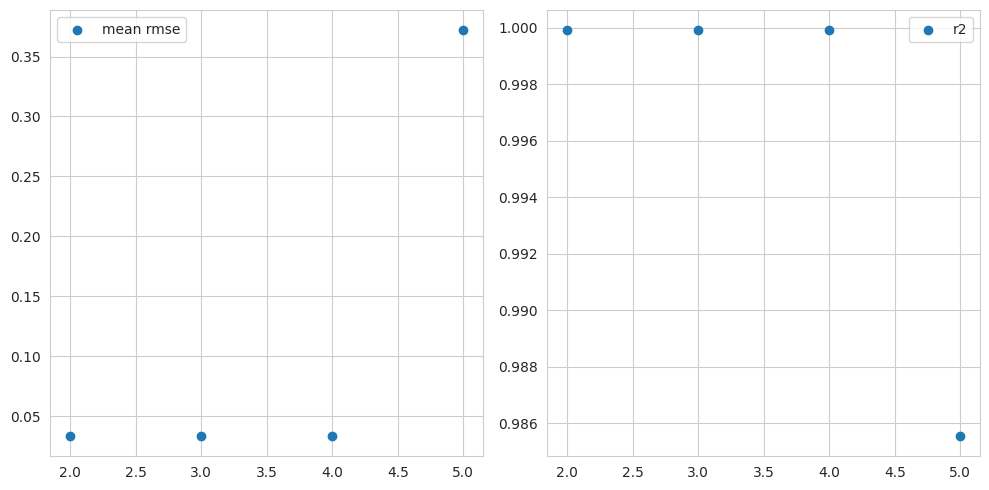

In [26]:
# I will perform a cross validation for different orders of polynomials to see which fits best

# Define the scoring metrics
scoring = {
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    'r2': 'r2'
}
mean_rmse = []
mean_r2 = []
for order in [2,3,4,5]:
    print(f'\n order : {order} polynomial')
    poly_model = make_pipeline(PolynomialFeatures(order), LinearRegression())
    scores = cross_validate_model(poly_model, X, y, f"{order}th polynomial")
    mean_rmse.append(- scores['test_neg_root_mean_squared_error'].mean())
    mean_r2.append( scores['test_r2'].mean())
f,axs = plt.subplots(ncols = 2 , figsize = (10,5))
axs[0].scatter([2,3,4,5] , mean_rmse   , label = 'mean rmse')
axs[1].scatter([2,3,4,5] , mean_r2   , label = 'r2')
axs[0].legend()
axs[1].legend()
plt.tight_layout()
# using 2,3,4 give more or less the same results for metrics. lets see how they fit

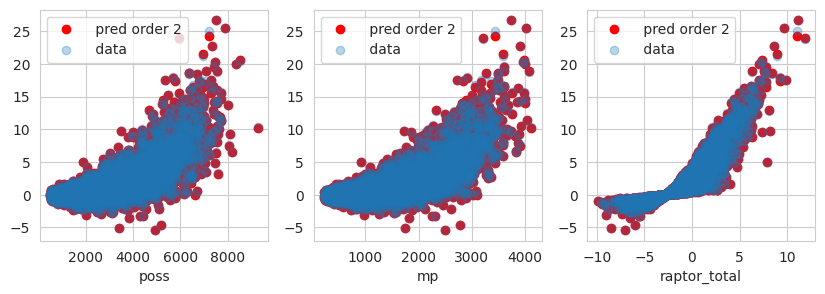

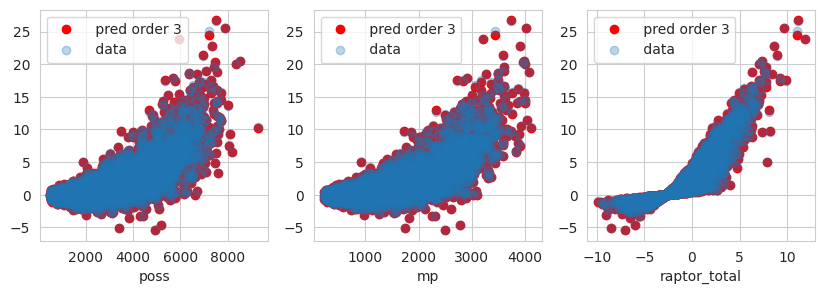

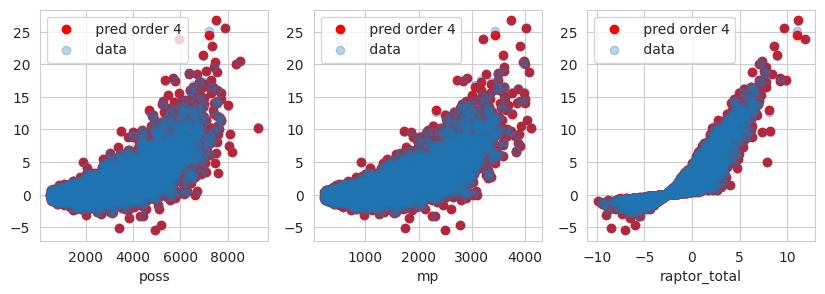

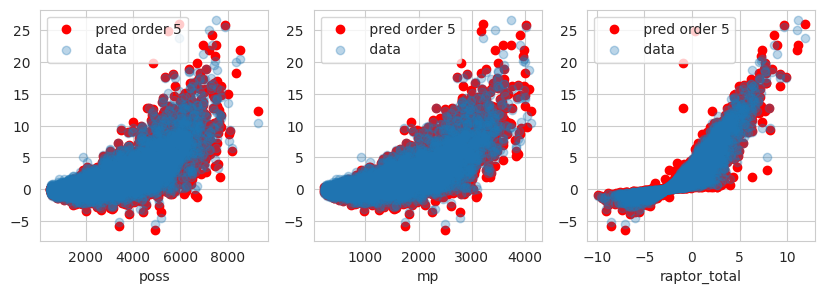

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for order in [2,3,4,5]:
    f,axs = plt.subplots(ncols = 3 , figsize = (10,3))
    poly_model = make_pipeline(PolynomialFeatures(order), LinearRegression())
    poly_model.fit(X_train, y_train)
    y_pred = poly_model.predict(X_test)
    axs[0].scatter(X_test['poss'] , y_pred , label = f' pred order {order}', color = 'r')
    axs[0].set_xlabel('poss')
    axs[1].scatter(X_test['mp'] , y_pred , label = f' pred order {order}', color = 'r')
    axs[1].set_xlabel('mp')
    axs[2].scatter(X_test['raptor_total'] , y_pred , label = f' pred order {order}', color = 'r')
    axs[2].set_xlabel('raptor_total')

    axs[0].scatter(X_test['poss'] , y_test , label = ' data' , alpha = 0.3)

    axs[1].scatter(X_test['mp'] , y_test , label = ' data' , alpha = 0.3)

    axs[2].scatter(X_test['raptor_total'] , y_test , label = ' data' , alpha = 0.3)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

# we'll use order 2 then

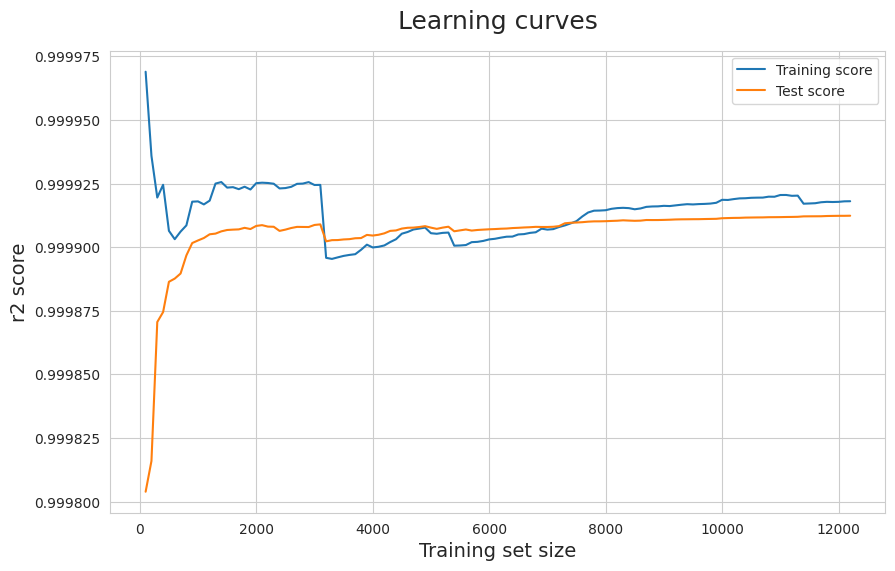

In [38]:
# Let's see the learning curves for a 2nd order polynomial
# Transform our X to include polynomial features
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(
    estimator = LinearRegression(),
    X = X_poly,
    y = y,
    train_sizes = np.arange(100,12300,100),
    cv = 5
)

# Take the mean of cross-validated train scores and test scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot the learning curves!
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
# plt.ylim(0.5,.7)
plt.legend();


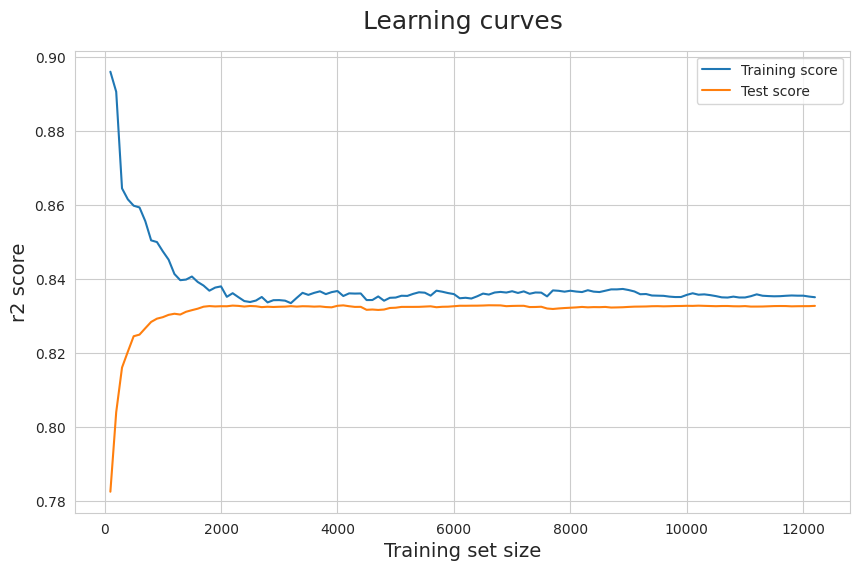

In [29]:
# the polynomial model is overfitting, lets take a step back and perform a linear regression on the engineered data
# Let's see the learning curves for a linear regression
# Transform our X to include polynomial features
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(
    estimator = LinearRegression(),
    X = X,
    y = y,
    train_sizes = np.arange(100,12300,100),
    cv = 5
)

# Take the mean of cross-validated train scores and test scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot the learning curves!
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
# plt.ylim(0.5,.7)
plt.legend();


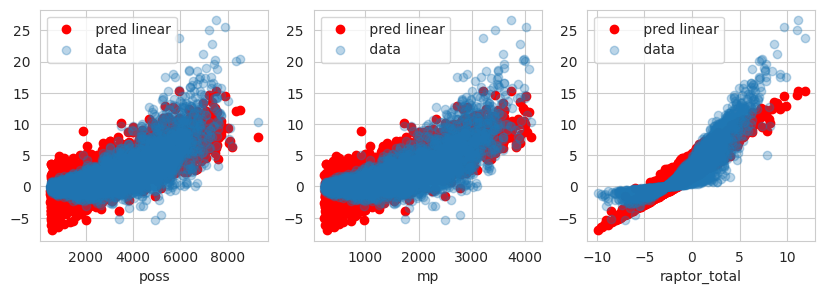

In [39]:
f,axs = plt.subplots(ncols = 3 , figsize = (10,3))
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)
axs[0].scatter(X_test['poss'] , y_pred , label = f' pred linear', color = 'r')
axs[0].set_xlabel('poss')
axs[1].scatter(X_test['mp'] , y_pred , label = f' pred linear', color = 'r')
axs[1].set_xlabel('mp')
axs[2].scatter(X_test['raptor_total'] , y_pred , label = f' pred linear', color = 'r')
axs[2].set_xlabel('raptor_total')

axs[0].scatter(X_test['poss'] , y_test , label = ' data' , alpha = 0.3)

axs[1].scatter(X_test['mp'] , y_test , label = ' data' , alpha = 0.3)

axs[2].scatter(X_test['raptor_total'] , y_test , label = ' data' , alpha = 0.3)
axs[0].legend()
axs[1].legend()
axs[2].legend()

# the results are reasonable, but trying to filter data so as to compensate overfitting in nonlinear models
# would be the way to go